In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
class Point:
    """Точка пересечения прямых"""
    
    def __init__(self, coord, cur_num=None, cur_line=None, next_num=None, next_line=None):
        """
        coord = [x, y] - координаты точки
        cur_num        - номер точки на текущей прямой
        cur_line       - номер текущей прямой
        next_num       - номер точки на следущей прямой
        next_line      - номер следующей прямой
        """
        self.coord = coord
        self.cur_num = cur_num
        self.cur_line = cur_line
        self.next_num = next_num
        self.next_line = next_line

    def __str__(self):
        return str(self.coord)


def intersection_lines(l1, l2):
    """Возвращает пересечение двух прямых, заданных парами точек:
    l1 = [x1, y1, x2, y2], l2 = [x1, y1, x2, y2]
    """
    a1 = [l1[2] - l1[0], l1[3] - l1[1]]
    a2 = [l2[2] - l2[0], l2[3] - l2[1]]
    m = [[a1[1], -a1[0], a1[1]*l1[0] - a1[0]*l1[1]],
         [a2[1], -a2[0], a2[1]*l2[0] - a2[0]*l2[1]]]
    det = m[0][0]*m[1][1] - m[0][1]*m[1][0]
    assert det != 0, "intersection_lines: прямые параллельны"
    d1 = m[0][2]*m[1][1] - m[0][1]*m[1][2]
    d2 = m[0][0]*m[1][2] - m[0][2]*m[1][0]
    return [d1/det, d2/det]

def draw_line(l, size=[-5,5,-5,5], color='blue'):
    """Построение прямой, заданной парой точек.
    l = [x1, y1, x2, y2]
    size = [x1, x2, y1, y2] - область построения: x in [x1, x2], y in [y1, y2]
    """
    var('x,y')
    a = [l[2] - l[0], l[3] - l[1]]
    return implicit_plot(a[1]*x - a[0]*y - a[1]*l[0] + a[0]*l[1],
                         (x, size[0], size[1]), (y, size[2], size[3]), color=color)

In [ ]:
"""
Задача:
  На плоскости даны прямые общего положения парами точек.
  (попарно непараллельны и все точки пересечения разные => см. кол-во
  пересечений)
  Прямые разбивают плоскость на области, среди которых есть компактные
  (внутренние) и нет.

  1) Обойти по границе максимальную компактную область.
  2) Перечислить все внутренние многоугольники.
"""

# lines_pairs - список прямых
#
# каждая задана парами точек A(x1,y1), B(x2,y2):
# lines_pairs = [l1, l2, ...]
# l1 = [x1, y1, x2, y2]
lines_pairs = [[0,0,1,2], [-1,0,2,-1], [2,-1,3,4], [0,4,4,0], [-4,0,2,4], [-2,6,0,-4]]
N = len(lines_pairs)

# lines_intersects - списки прямых с лежащими на них точками пересечений
#
# lines_intersects = [L1, L2, ...]
# L1 = [p1, p2, ...]
# p1 = Point([x1,y1], cur_num, cur_line, next_num, next_line)
lines_intersects = [[] for i in range(N)]

# intersects - список точек пересечения
#
# intersects = [p1, p2, ...]
# p1 = [x1, y1]
intersects = []

for i in range(N):
    for j in range(i+1, N):
        x = intersection_lines(lines_pairs[i], lines_pairs[j])
        intersects.append(x)
        
        # добавляем точку пересечения в lines_intersects сразу с сортировкой
        num = len(lines_intersects[i])
        for k in range(len(lines_intersects[i])):
            if x[0] <= lines_intersects[i][k].coord[0]:
                num = k
                break
        lines_intersects[i].insert(num, Point(x, cur_line = i, next_line = j))
        
        num = len(lines_intersects[j])
        for k in range(len(lines_intersects[j])):
            if x[0] <= lines_intersects[j][k].coord[0]:
                num = k
                break
        lines_intersects[j].insert(num, Point(x, cur_line = j, next_line = i))

# добавление next_num для p1 = [[x1,y1], cur_num, cur_line, next_num, next_line]
for i in range(N):
    for j in range(N-1):
        lines_intersects[i][j].cur_num = j
        coord = lines_intersects[i][j].coord
        next_line = lines_intersects[i][j].next_line
        for k in range(N-1):
            if lines_intersects[next_line][k].coord == coord:
                lines_intersects[i][j].next_num = k
                break

In [ ]:
print('drawing...')
p = plot([])
plot_size = [-6,8,-8,10]
for i in lines_pairs:
    p += draw_line(i, plot_size)
for i in intersects:
    p += point(i, color='red', size=20, zorder=2)
    p += text(i, [i[0], i[1]], color='green', alpha=0.7, zorder=2)
p.show()

In [ ]:
def get_orientation(prev, cur, next):
    """Выдает ориентацию векторов BA и BC по точкам A, B, C
    A = prev = [x1, y1]
    B = cur  = [x2, y2]
    C = next = [x3, y3]
    """
    return sign((prev[0]-cur[0])*(next[1]-cur[1]) - 
                (next[0]-cur[0])*(prev[1]-cur[1]))

prev_point = None
cur_point = None
next_point = None
first = None

# Выбор начальной конфигурации точек:
# для cur_point найдем крайнюю точку на двух прямых
for i in range(N):
   if lines_intersects[i][0].next_num in [0, N-2]:
       cur_point = lines_intersects[i][0]
       break
   elif lines_intersects[i][N-2].next_num in [0, N-2]:
       cur_point = lines_intersects[i][N-2]
       break

# для prev_point возьмем соседнюю с cur_point
if cur_point.cur_num < N-2:
    prev_point = lines_intersects[cur_point.cur_line][cur_point.cur_num + 1]
elif cur_point.cur_num > 0:
    prev_point = lines_intersects[cur_point.cur_line][cur_point.cur_num - 1]

# для next_point возьмем соседнюю с cur_point на next_line
if cur_point.next_num < N-2:
    next_point = lines_intersects[cur_point.next_line][cur_point.next_num + 1]
elif cur_point.next_num > 0:
    next_point = lines_intersects[cur_point.next_line][cur_point.next_num - 1]

first = cur_point.coord
outer_cycle = [first]
orient = -get_orientation(prev_point.coord, cur_point.coord, next_point.coord)

while not next_point.coord == first:
    # следующая НЕ крайняя - поворачиваем
    if 0 < next_point.next_num < N-2:
        prev_point = cur_point
        cur_point = next_point
        outer_cycle.append(cur_point.coord)

        if get_orientation(prev_point.coord, cur_point.coord,
                           lines_intersects[cur_point.next_line][cur_point.next_num + 1].coord) == orient:
            next_point = lines_intersects[cur_point.next_line][cur_point.next_num + 1]
        else:
            next_point = lines_intersects[cur_point.next_line][cur_point.next_num - 1]
    # следующая крайняя
    else:
        prev_point = cur_point
        cur_point = next_point
        outer_cycle.append(cur_point.coord)

        # проходим мимо крайней, которая не последняя на текущей прямой:
        if 0 < cur_point.cur_num < N-2:
            if lines_intersects[cur_point.cur_line][cur_point.cur_num + 1].coord == prev_point.coord:
                next_point = lines_intersects[cur_point.cur_line][cur_point.cur_num - 1]
            else:
                next_point = lines_intersects[cur_point.cur_line][cur_point.cur_num + 1]
        # сворачиваем по единственному варианту:
        else:
            if cur_point.next_num < N-2:
                next_point = lines_intersects[cur_point.next_line][cur_point.next_num + 1]
            elif cur_point.next_num > 0:
                next_point = lines_intersects[cur_point.next_line][cur_point.next_num - 1]

print(outer_cycle)

In [ ]:
print('drawing outer cycle...')
p = plot([])
#plot_size = [-6,8,-5,10]
for i in lines_pairs:
    p += draw_line(i, plot_size)
count = 0
for i in outer_cycle:
    count += 1
    p += point(i, color='red', size=20, zorder=2)
    p += text(count, [i[0]+0.5, i[1]-0.5], color='green', zorder=2)
p.show()

In [ ]:
passed_points = []    # список уже просмотренных точек
polygons = []

def get_next_orient(prev, cur, orient):
    if cur.next_num > 0 \
       and get_orientation(prev.coord, cur.coord,
                           lines_intersects[cur.next_line][cur.next_num - 1].coord) == orient:
        return lines_intersects[cur.next_line][cur.next_num - 1]
    if cur.next_num < N-2 \
       and get_orientation(prev.coord, cur.coord,
                           lines_intersects[cur.next_line][cur.next_num + 1].coord) == orient:
        return lines_intersects[cur.next_line][cur.next_num + 1]
    return None    # по направлению orient свернуть нельзя


for cur_line in lines_intersects:
    for i in range(N-2):
        first = cur_line[i]
        second = cur_line[i+1]
        if first.coord in passed_points or second.coord in passed_points:
            continue
        passed_points.append(first.coord)

        if second.next_num < N-2:    # можно повернуть направо
            prev_point = first
            cur_point = second
            next_point = lines_intersects[cur_point.next_line][cur_point.next_num + 1]
            orient = get_orientation(prev_point.coord, cur_point.coord, next_point.coord)
            cur_polygon = [prev_point.coord, cur_point.coord]

            while next_point and (next_point.coord not in passed_points):
                  # and (not next_point.coord == first.coord) и так проверяется
                prev_point = cur_point
                cur_point = next_point
                cur_polygon.append(cur_point.coord)
                next_point = get_next_orient(prev_point, cur_point, orient)

            if next_point and next_point.coord == first.coord:
                polygons.append(cur_polygon)

        if second.next_num > 0:
            prev_point = first
            cur_point = second
            next_point = lines_intersects[cur_point.next_line][cur_point.next_num - 1]
            orient = get_orientation(prev_point.coord, cur_point.coord, next_point.coord)
            cur_polygon = [prev_point.coord, cur_point.coord]

            while next_point and (next_point.coord not in passed_points):
                prev_point = cur_point
                cur_point = next_point
                cur_polygon.append(cur_point.coord)
                next_point = get_next_orient(prev_point, cur_point, orient)

            if next_point and next_point.coord == first.coord:
                polygons.append(cur_polygon)
    passed_points.append(cur_line[N-2].coord)

In [ ]:
for i in polygons:
    print(i)

In [ ]:
print('drawing inner polygons...')
p = plot([])
for i in range(len(polygons)):
    p += polygon2d(polygons[i], edgecolor='black',
                   rgbcolor=(random(), random(), random()))
p.show()

In [ ]:
center_weights = []
for i in polygons:
    sum_x=0
    sum_y=0
    for j in i:
        sum_x +=j[0]
        sum_y +=j[1]
    center_weights.append([sum_x/len(i),sum_y/len(i)])
print(center_weights)

drawing...


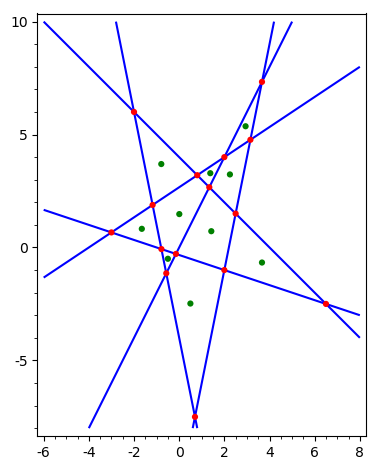

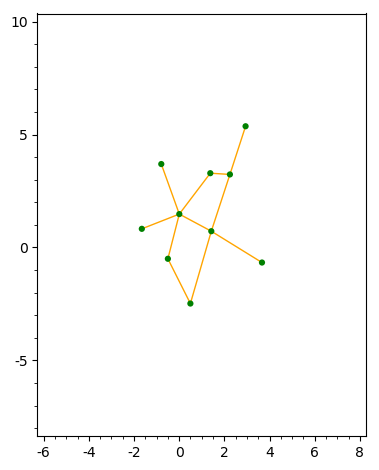

In [11]:
print('drawing...')
p = plot([])
plot_size = [-6,8,-8,10]
for i in lines_pairs:
    p += draw_line(i, plot_size)
for i in intersects:
    p += point(i, color='red', size=20, zorder=2)
for i in center_weights:
    p += point(i, color='green', size=20, zorder=2)
p.show()
p = plot([])
M = matrix(len(polygons))
for i in range(len(polygons)):
    for j in range(i + 1, len(polygons)):
        for k in range(len(polygons[i]) - 1):
            if (polygons[i][k] in polygons[j]) and (polygons[i][k + 1] in polygons[j]): 
                M[i,j] = 1
                p += line([center_weights[i],center_weights[j]],color='orange', zorder=2)
for i in center_weights:
    p += point(i, color='green', size=20, zorder=3)
for i in lines_pairs:
    p += draw_line(i, plot_size, 'white')
p.show()